# 1. Import libraries

In [1]:
# Import necessary libraries
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# From here, add any libraries that you might need for the rest of your code
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
from random import randint
from tensorflow.keras import Sequential, layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
from itertools import product

2024-09-29 13:54:16.689810: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-29 13:54:16.701561: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-29 13:54:16.714721: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-29 13:54:16.719060: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-29 13:54:16.729649: I tensorflow/core/platform/cpu_feature_guar

# 2. Load and pre-process the dataset

In [2]:
# Set the paths to the data directories
data_dir ='archive' # Change to the path to your directory
train_images_dir = os.path.join(data_dir, 'Training')
test_images_dir = os.path.join(data_dir, 'Testing')

print(f"Data directory: {data_dir}")
print(f"Training directory: {train_images_dir}")
print(f"Testing directory: {test_images_dir}")


Data directory: archive
Training directory: archive/Training
Testing directory: archive/Testing


In [3]:
## IMPORTANT: please remember that you are not allowed to change the
## loading and preprocessing code to improve model performance for this assignment.

# Load and preprocess the data
np.random.seed(seed=42)
def add_noise(img):
    std_coeff = 70*np.random.random()
    noise = np.random.normal(0, std_coeff, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

image_res = 30
def get_images(train_dir: str, test_dir: str):
    datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=add_noise)

    img_height, img_width = image_res, image_res
    batch_size = 32

    # Load training data
    train_data = datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        color_mode='grayscale'
    )

    # Load test data
    test_data = datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        color_mode='grayscale'
    )

    return train_data, test_data

# Load the training and test data
try:
    train_data, test_data = get_images(train_images_dir, test_images_dir)
    print("Data loading completed successfully.")
    print(f"Number of training samples: {train_data.samples}")
    print(f"Number of test samples: {test_data.samples}")
    print(f"Class names: {train_data.class_indices}")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Data loading completed successfully.
Number of training samples: 5712
Number of test samples: 1311
Class names: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


# 3. Visualise data and plot data distribution

In [4]:
# Create a list with class names
class_indices = train_data.class_indices
class_names = []
for x in class_indices.keys():
    class_names.append(x)

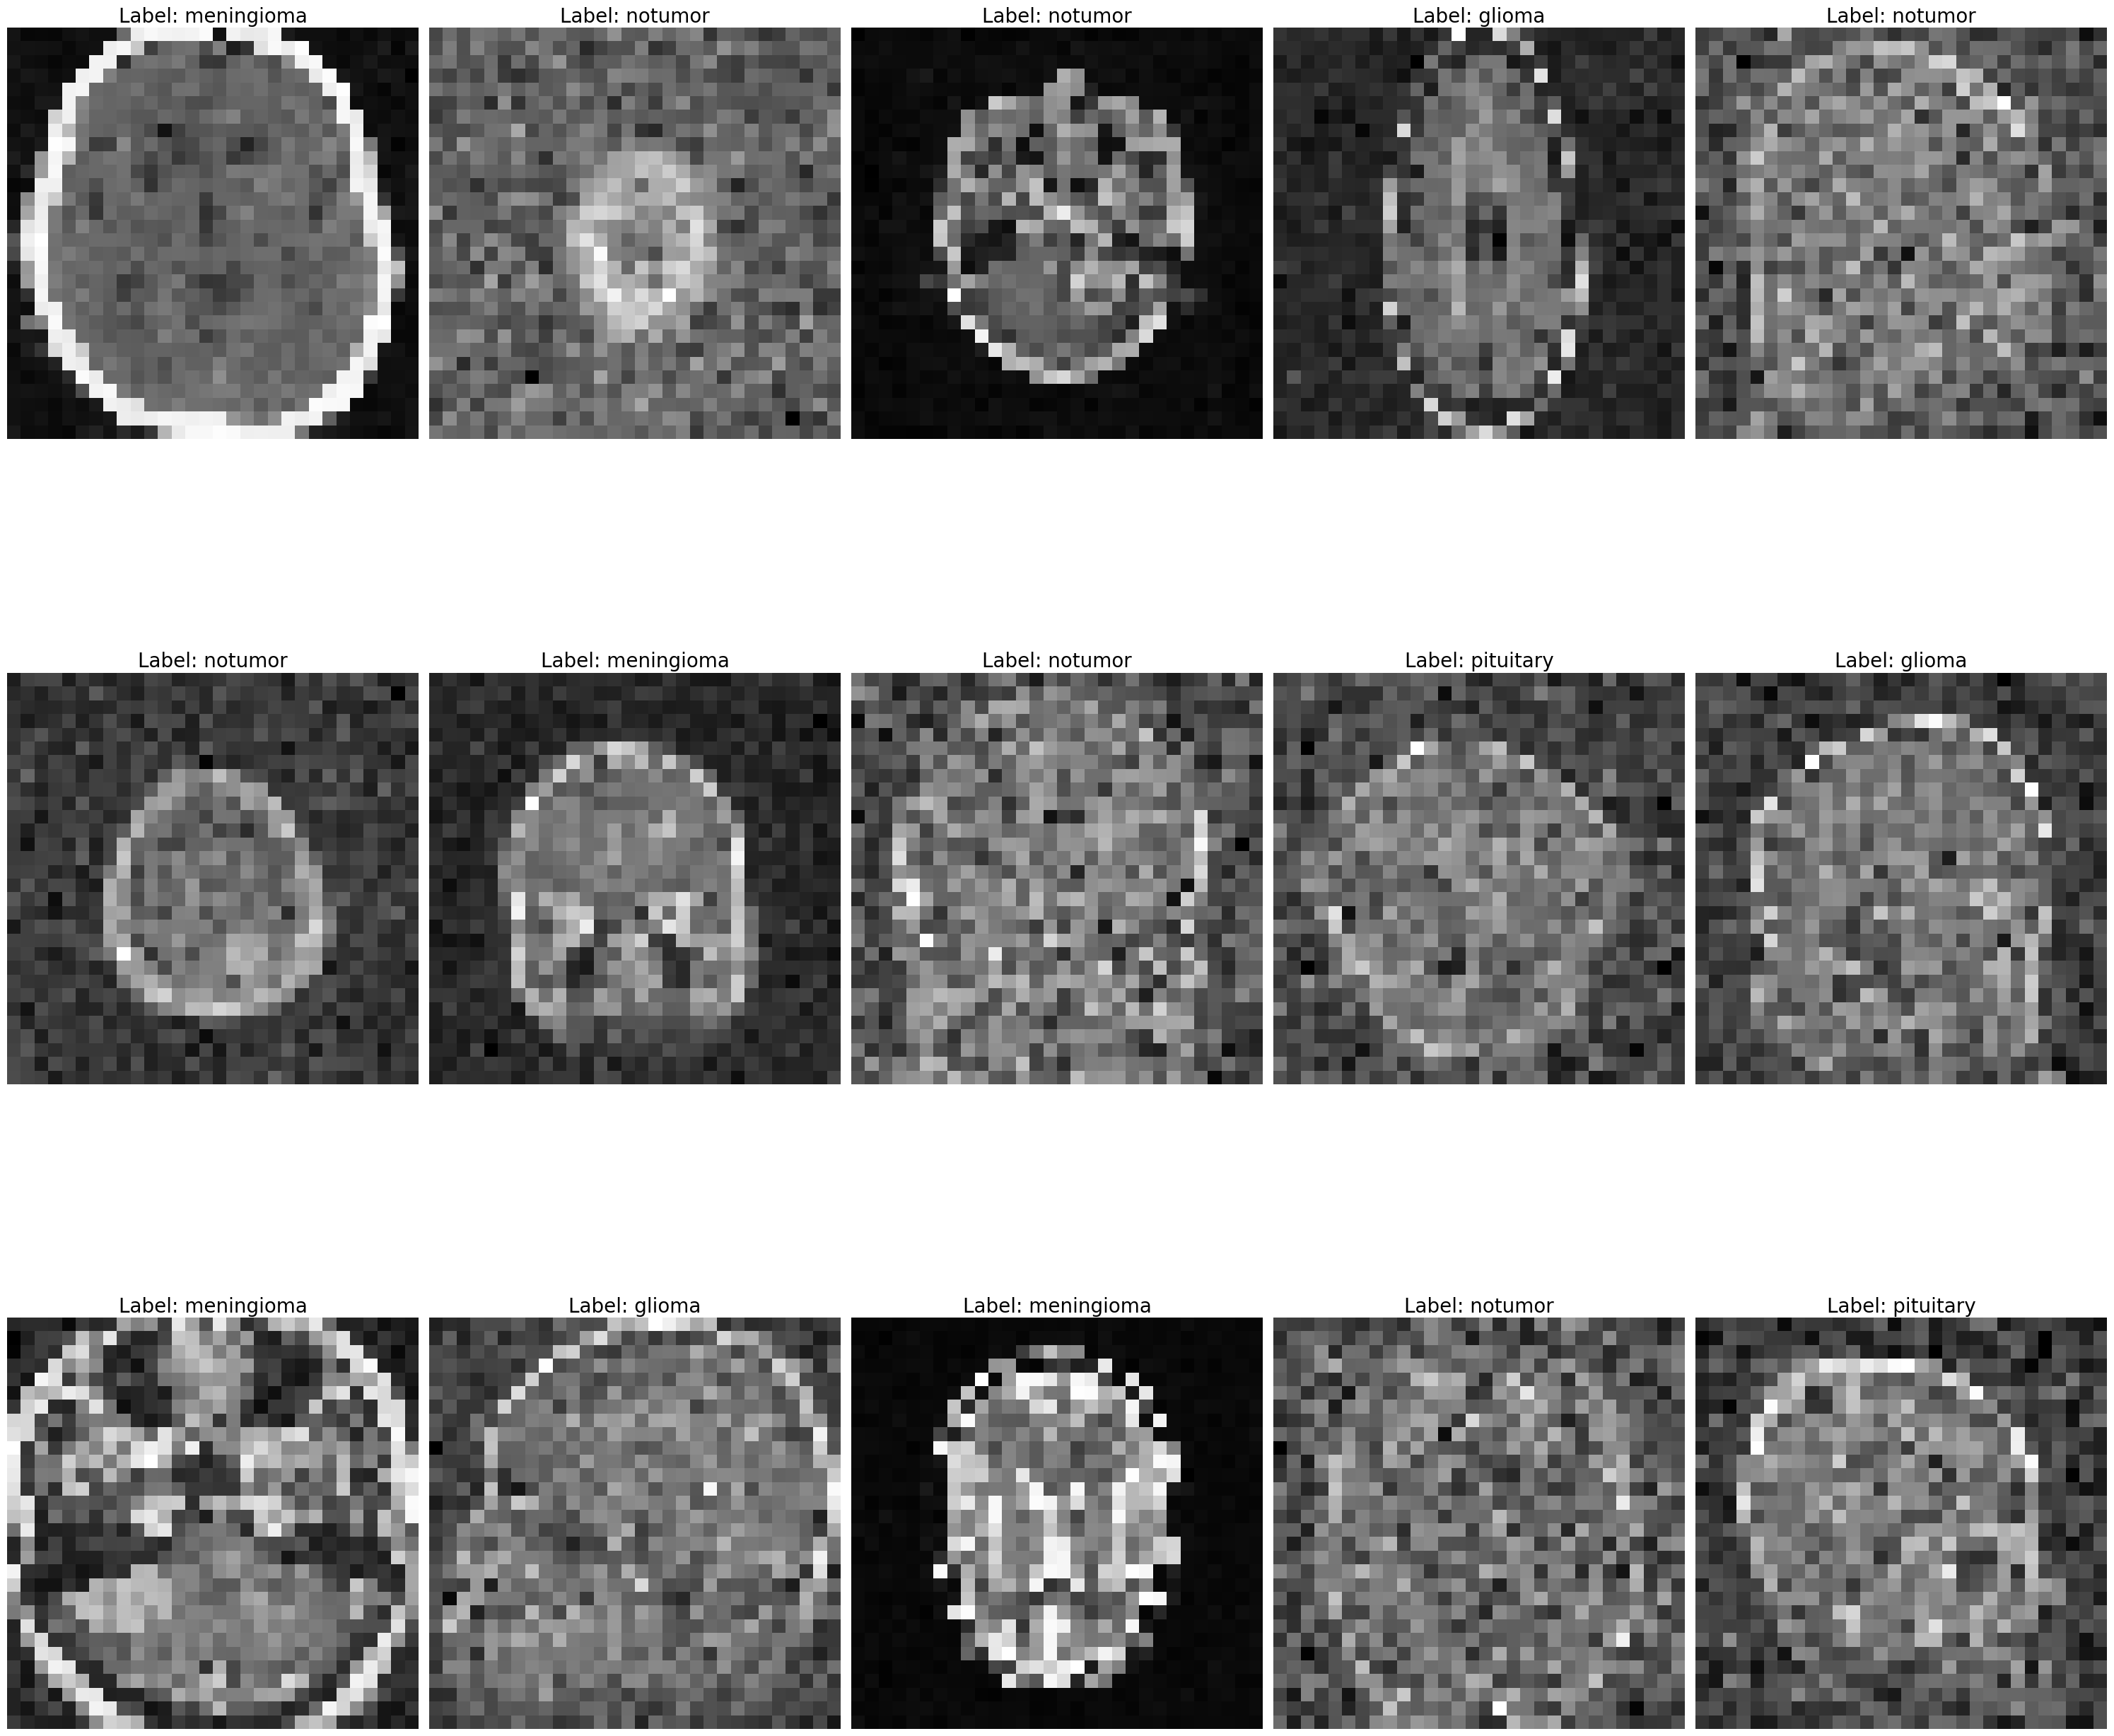

In [5]:
# Randomly select 15 samples from the dataset. For each selected sample, display the image along with its corresponding label as text on top of the image.
# Arrange these images and labels in a single figure, ensuring that they are visually clear and labeled properly.

# Choosing a random batch from the 175
images, num_labels = train_data[randint(0, 174)]

# Creating the numerical labels and converting them to their class name
num_labels = np.argmax(num_labels, axis=1)
class_labels = []
for x in num_labels:
    class_labels.append(class_names[x])

# Plotting the figure
plt.figure(figsize=(30, 30))

# Choosing 15 random pictures from the batch
random_image = random.sample(range(31), 15)
for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(images[random_image[i]].squeeze(), cmap="gray")
    plt.title(f"Label: {class_labels[i]}", fontsize=20)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [6]:
# Create a bar plot to visualize the class label distribution of the dataset. (Hint: this bar plot reveals how many samples the dataset has for each class)
# Count how many there are of each class for the training data
class_counts = [0, 0, 0, 0]
for images, labels in train_data:
    for label in labels:
        class_index = np.argmax(label)
        class_counts[class_index] += 1
    # Make sure the code stops running when the last batch is smaller than the batch_size
    if len(images) < train_data.batch_size:
        class_index = np.argmax(label)
        class_counts[class_index] += 1
        break

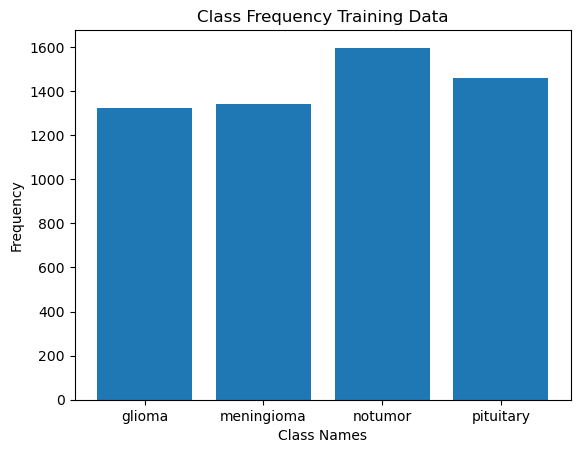

In [7]:
# Create the barplot
# Add class_counts and class_names
frequency = class_counts
bars = class_names
y_pos = np.arange(len(bars))

plt.bar(y_pos, frequency)
plt.xticks(y_pos, bars)

# Add names to plot,x-axis and y-axis
plt.title('Class Frequency Training Data')
plt.xlabel('Class Names')
plt.ylabel('Frequency')

plt.show()

In [8]:
# Create counts for the test data
class_counts2 = [0, 0, 0, 0]
for images, labels in test_data:
    for label in labels:
        class_index = np.argmax(label)
        class_counts2[class_index] += 1
    if len(images) < test_data.batch_size:
        class_index = np.argmax(label)
        class_counts2[class_index] += 1
        break

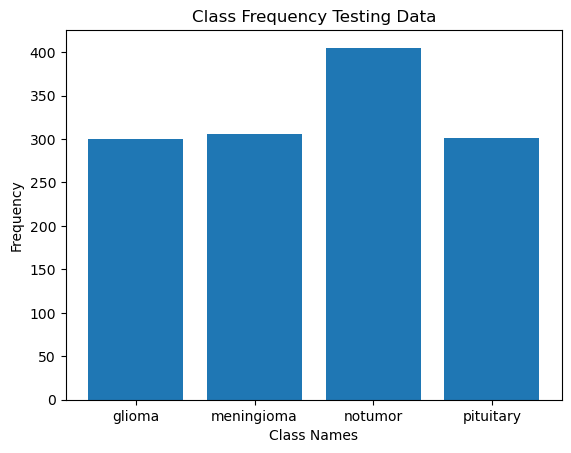

In [9]:
# Create the barplot
# Add class_counts and class_names
frequency = class_counts2
bars = class_names
y_pos = np.arange(len(bars))

plt.bar(y_pos, frequency)
plt.xticks(y_pos, bars)

plt.title('Class Frequency Testing Data')
plt.xlabel('Class Names')
plt.ylabel('Frequency')

plt.show()

# 4. Train and Evaluation functions

In [10]:
# Set the validation split ratio to 0.2 (20%)
validation_split = 0.2

# Create a new ImageDataGenerator with validation_split
datagen_with_split = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=add_noise,
    validation_split=validation_split)

img_height, img_width = image_res, image_res
batch_size = 32

# Create the training data generator
train_generator = datagen_with_split.flow_from_directory(
    train_images_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True,
    subset='training')

# Create the validation data generator
validation_generator = datagen_with_split.flow_from_directory(
    train_images_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True,
    subset='validation')

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


Implement the baseline CNN algorithm (exactly, without any modification for both
model and dataset) that is shown in Fig. 1. It is a network consisting of: a Convo-
lutional layer with 32 filters and kernel size of 3 × 3 with ReLU activations that is
followed by a max pooling layer of size 2 × 2 and again a convolutional layer of 32
filters of size 3 × 3 with ReLU activations. Each convolutional layer is followed by a
MaxPooling layer with a size of 2 × 2. Finally, a dense layers of sizes 32 and with Relu activation function and an output layer with the proper activation function (you are
expected to find out) are added. The number of epochs should be set as 10 and batch
size as 32 (is already set in the preprocessing code). The optimizer should be Adam,
the metric should be accuracy and the loss function is expected from you :-).

In [11]:
baseline_model = Sequential()

# Convolutional layer with 32 filters and kernel size of 3 × 3 with ReLU activations
baseline_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(30, 30, 1)))
# Max pooling layer of size 2 × 2
baseline_model.add(layers.MaxPooling2D((2, 2)))
# convolutional layer of 32 filters of size 3 × 3 with ReLU activations
baseline_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
# MaxPooling layer with a size of 2 × 2.
baseline_model.add(layers.MaxPooling2D((2, 2)))

baseline_model.add(layers.Flatten())
# Dense layers of sizes 32 and with Relu activation function
baseline_model.add(layers.Dense(32, activation='relu'))
# Output layer with the proper activation function
baseline_model.add(layers.Dense(4, activation='softmax'))

baseline_model.summary()

/home/guido/anaconda3/envs/tfenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1727610871.877554   37720 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727610871.920162   37720 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727610871.920215   37720 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727610871.923247   37720 c

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,596 (182.02 KB)

 Trainable params: 46,596 (182.02 KB)

 Non-trainable params: 0 (0.00 B)

# 5. Model training

In [12]:
# The number of epochs should be set as 10 and batch size as 32 (is already set in the preprocessing code). 
# The optimizer should be Adam, the metric should be accuracy and the loss function is categorical_crossentropy.
num_epochs = 10
baseline_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
original_hist = baseline_model.fit(train_generator, epochs=10, batch_size=32, validation_data=validation_generator)
test_loss, test_acc = baseline_model.evaluate(test_data)
print("Test accuracy", test_acc)

Epoch 1/10


/home/guido/anaconda3/envs/tfenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1727610874.056549   37987 service.cc:146] XLA service 0x7f614c015bb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727610874.056584   37987 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2024-09-29 13:54:34.072530: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-29 13:54:34.148787: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  6/143 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.2994 - loss: 1.3609

I0000 00:00:1727610875.242362   37987 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.4390 - loss: 1.1996 - val_accuracy: 0.6477 - val_loss: 0.9847
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.6891 - loss: 0.7813 - val_accuracy: 0.6266 - val_loss: 0.9082
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.7432 - loss: 0.6696 - val_accuracy: 0.6748 - val_loss: 0.8668
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.7756 - loss: 0.5774 - val_accuracy: 0.6635 - val_loss: 0.8646
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.7830 - loss: 0.5502 - val_accuracy: 0.6792 - val_loss: 0.8658
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.7966 - loss: 0.5435 - val_accuracy: 0.6941 - val_loss: 0.8598
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.8164 - loss: 0.5013 - val_accuracy: 0.6827 - val_loss: 0.8282
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.8081 - loss: 0.4812 - val_accuracy: 0.69

# 6. Model evaluation

Analyze the performance of the baseline by plotting: (i) the training and validation
losses and accuracies on the training and validation set through epochs (similar to
Fig. 2a and Fig. 2b), (ii) the Receiver Operator Characteristic (ROC) curve with the
Area under the Curve (AUC) score and a confusion matrix for the validation and
test sets. Examples of accuracy and loss plots are shown in Fig. 2, and an example of a
ROC curve and confusion matrix is shown in Fig. 3, respectively. Report performance
measures (accuracy, precision, recall, and F1-score) for both validation and test
sets. You can find the hint for plotting multi-class ROC curve here: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [13]:
history_dict = original_hist.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [14]:
def plot_history(data_list, label_list, title, ylabel):
    epochs = range(1, len(data_list[0]) + 1)
    for data, label in zip(data_list, label_list):
        plt.plot(epochs, data, label=label)
        plt.title(title)
        plt.xlabel('Epochs')
        plt.ylabel(ylabel)
        plt.legend()
        plt.show()

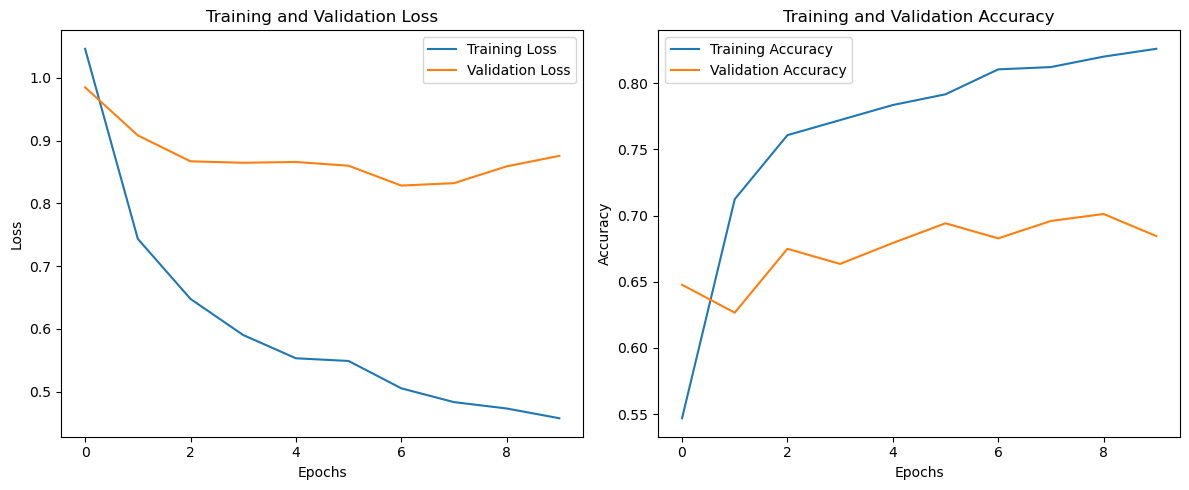

In [15]:
# Plot of the training and validation losses and accuracies on the training and validation set through epochs
%matplotlib inline

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Create 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Training and Validation Loss
ax1.plot(loss, label='Training Loss')
ax1.plot(val_loss, label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Training and Validation Accuracy
ax2.plot(acc, label='Training Accuracy')
ax2.plot(val_acc, label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

In [16]:
# Function to compute ROC curves and AUC
def compute_roc_auc(model, data_generator):
    y_true = []
    y_pred = []

    data_generator.reset()
    for i in range(len(data_generator)):
        images, labels = data_generator[i]
        preds = model.predict(images, verbose=0)
        y_true.extend(labels)
        y_pred.extend(preds)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    num_classes = data_generator.num_classes
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average AUC
    macro_auc = roc_auc_score(y_true, y_pred, average='macro')

    return fpr, tpr, roc_auc, macro_auc

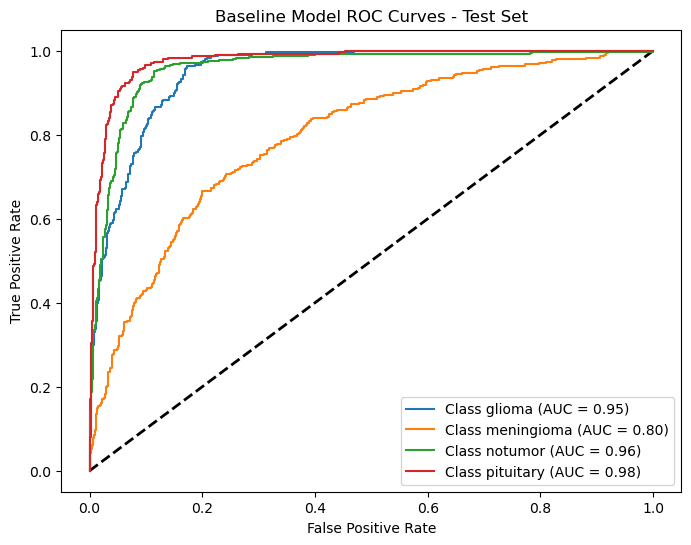

Test Set Macro AUC - Baseline Model: 0.92


In [17]:
# Compute ROC curves with compute_roc_auc()
baseline_fpr_test, baseline_tpr_test, baseline_roc_auc_test, baseline_macro_auc_test = compute_roc_auc(baseline_model, test_data)

# Plot ROC curves for the test set
plt.figure(figsize=(8, 6))

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
for i in range(test_data.num_classes):
    plt.plot(baseline_fpr_test[i], baseline_tpr_test[i],
             label='Class {} (AUC = {:.2f})'.format(class_names[i], baseline_roc_auc_test[i]))

plt.title('Baseline Model ROC Curves - Test Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

plt.show()

print(f'Test Set Macro AUC - Baseline Model: {baseline_macro_auc_test:.2f}')

In [18]:
# Function to compute confusion matrix
def get_confusion_matrix(model, data_generator):
    y_true = []
    y_pred = []

    data_generator.reset()
    for i in range(len(data_generator)):
        images, labels = data_generator[i]
        preds = model.predict(images, verbose=0)
        predicted_labels = np.argmax(preds, axis=1)
        true_labels = np.argmax(labels, axis=1)
        y_true.extend(true_labels)
        y_pred.extend(predicted_labels)

    conf_matrix = confusion_matrix(y_true, y_pred)
    return conf_matrix

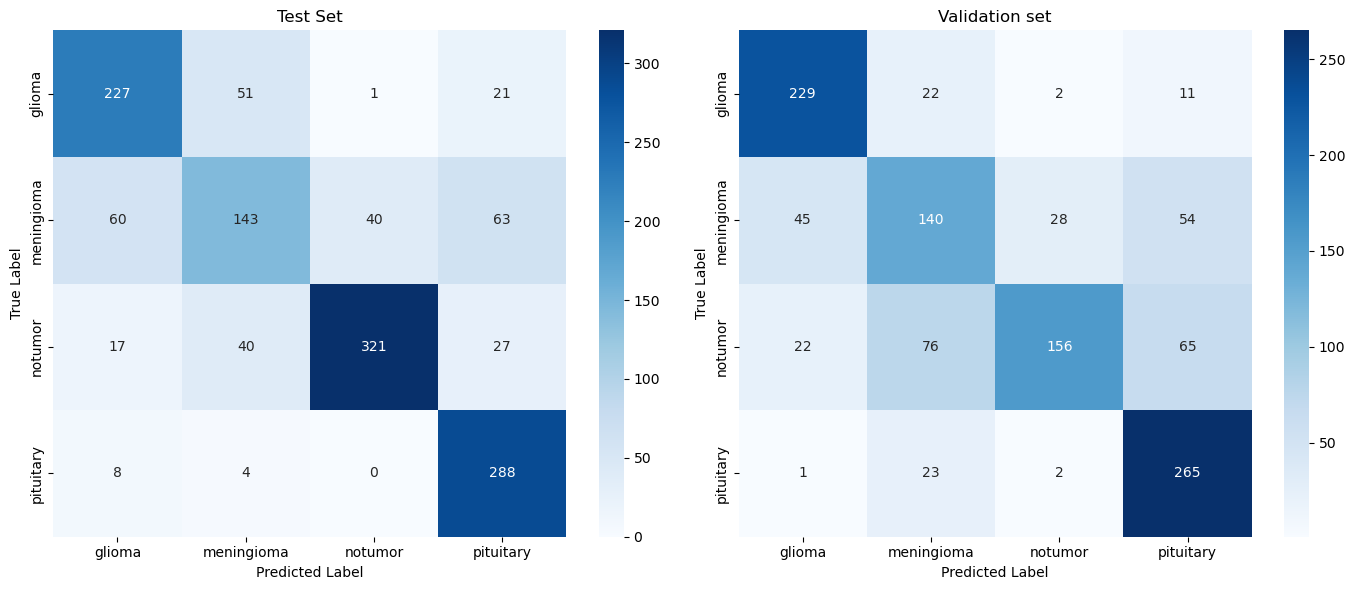

In [19]:
# Get confusion matrices with get_confusion_matrix()
conf_matrix_test = get_confusion_matrix(baseline_model, test_data)
conf_matrix_val = get_confusion_matrix(baseline_model, validation_generator)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Test set confusion matrix
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title('Test Set')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Validation set confusion matrix
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title('Validation set')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

Once you have a baseline model, adapt/fine-tune the network to improve its performance by: (i) changing the hyper-parameters. It is critical to intentionally tweak at
least six different hyperparameters, ensuring that these adjustments are not randomly
chosen. You are expected to make purposeful selections based on the intricacies of
the problem at hand, and conduct optimization within a logical framework. Consider
changes such as the addition of more layers, alterations in filter sizes and numbers, adjustments to activation functions, fine-tuning the learning rate together with different
optimizers, and experimenting with the number of neurons in Dense layers. Document
and analyze the rationale/reasoning behind each modification in your report. Illustrate the improvements of your new network over the baseline by: (a) plotting the
ROC curve with the AUC score; and (b) reporting performance measures. Compare
and explain the differences between the two models as well as potential reasons behind
the increase/decrease in performance.

# 7. Improve baseline model

In [35]:
# Function to create the improved model
def create_improved(optimizer='adam', dropout_rate=0.5, l2_regularization=0.01, filters=32, activation='relu', learning_rate=0.001):
    model_improved = Sequential()

    model_improved.add(layers.Conv2D(filters, (3, 3), activation=activation, input_shape=(30, 30, 1),
                                     kernel_regularizer=l2(l2_regularization)))
    model_improved.add(layers.MaxPooling2D((2, 2)))
    model_improved.add(layers.Conv2D(filters, (3, 3), activation=activation,
                                     kernel_regularizer=l2(l2_regularization)))
    model_improved.add(layers.MaxPooling2D((2, 2)))

    model_improved.add(layers.Flatten())
    model_improved.add(layers.Dense(32, activation=activation, kernel_regularizer=l2(l2_regularization)))
    model_improved.add(Dropout(dropout_rate))
    model_improved.add(layers.Dense(4, activation='softmax'))

    # Adjust optimizer learning rate if applicable
    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        opt = optimizer

    model_improved.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model_improved

# Define the parameter grid
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.5, 0.4, 0.3],
    'l2_regularization': [0.1, 0.01, 0.001],
    'filters': [32, 64],
    'activation': ['relu', 'tanh'],
    'learning_rate': [0.001, 0.0001]
}

# Generate all possible combinations of parameters
param_names = list(param_grid.keys())
param_values = list(param_grid.values())

param_combinations = list(product(*param_values))
print(f"Total number of possible combinations: {len(param_combinations)}")

# Randomly sample combinations to reduce computation time
random.seed(42)
n_samples = 50
random_combinations = random.sample(param_combinations, n_samples)
print(f"Testing {n_samples} random combinations.")

best_val_accuracy = 0
best_params = {}
results = []

epochs = 10

# Loop over each combination
for param_combination in random_combinations:
    params = dict(zip(param_names, param_combination))
    print(f"\nTraining with parameters: {params}")

    # Create the model with the current hyperparameters
    model = create_improved(optimizer=params['optimizer'],
                            dropout_rate=params['dropout_rate'],
                            l2_regularization=params['l2_regularization'],
                            filters=params['filters'],
                            activation=params['activation'],
                            learning_rate=params['learning_rate'])

    # Train the model, including validation data
    history = model.fit(train_generator,
                        epochs=epochs,
                        validation_data=validation_generator,
                        verbose=0)

    # Get the final validation accuracy
    final_val_accuracy = history.history['val_accuracy'][-1]
    print(f"Validation accuracy: {final_val_accuracy}")

    # Save the results for analysis
    results.append({
        'optimizer': params['optimizer'],
        'dropout_rate': params['dropout_rate'],
        'l2_regularization': params['l2_regularization'],
        'filters': params['filters'],
        'activation': params['activation'],
        'learning_rate': params['learning_rate'],
        'val_accuracy': final_val_accuracy
    })

    # Update the best parameters if this run has the highest validation accuracy
    if final_val_accuracy > best_val_accuracy:
        best_val_accuracy = final_val_accuracy
        best_params = params

# Print the best parameters and accuracy
print(f"\nBest validation accuracy: {best_val_accuracy}")
print(f"Best hyperparameters: {best_params}")

# Create the best model
best_model = create_improved(optimizer=best_params['optimizer'],
                             dropout_rate=best_params['dropout_rate'],
                             l2_regularization=best_params['l2_regularization'],
                             filters=best_params['filters'],
                             activation=best_params['activation'],
                             learning_rate=best_params['learning_rate'])

# Use EarlyStopping to retrain the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the best model with early stopping
history = best_model.fit(train_generator,
                         epochs=100,
                         validation_data=validation_generator,
                         callbacks=[early_stopping],
                         verbose=1)

best_history = history
test_loss, test_acc = best_model.evaluate(test_data)
print(f"Test accuracy: {test_acc}")


Total number of possible combinations: 144
Testing 50 random combinations.

Training with parameters: {'optimizer': 'adam', 'dropout_rate': 0.4, 'l2_regularization': 0.1, 'filters': 64, 'activation': 'relu', 'learning_rate': 0.001}


/home/guido/anaconda3/envs/tfenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation accuracy: 0.6739702224731445

Training with parameters: {'optimizer': 'adam', 'dropout_rate': 0.5, 'l2_regularization': 0.1, 'filters': 64, 'activation': 'tanh', 'learning_rate': 0.001}
Validation accuracy: 0.6757230758666992

Training with parameters: {'optimizer': 'adam', 'dropout_rate': 0.3, 'l2_regularization': 0.001, 'filters': 64, 'activation': 'tanh', 'learning_rate': 0.001}
Validation accuracy: 0.7055214643478394

Training with parameters: {'optimizer': 'adam', 'dropout_rate': 0.3, 'l2_regularization': 0.01, 'filters': 64, 'activation': 'tanh', 'learning_rate': 0.001}
Validation accuracy: 0.7055214643478394

Training with parameters: {'optimizer': 'adam', 'dropout_rate': 0.3, 'l2_regularization': 0.01, 'filters': 32, 'activation': 'relu', 'learning_rate': 0.0001}
Validation accuracy: 0.6906222701072693

Training with parameters: {'optimizer': 'adam', 'dropout_rate': 0.4, 'l2_regularization': 0.01, 'filters': 32, 'activation': 'tanh', 'learning_rate': 0.0001}
Validati

## Plot evaluation metrics on both models

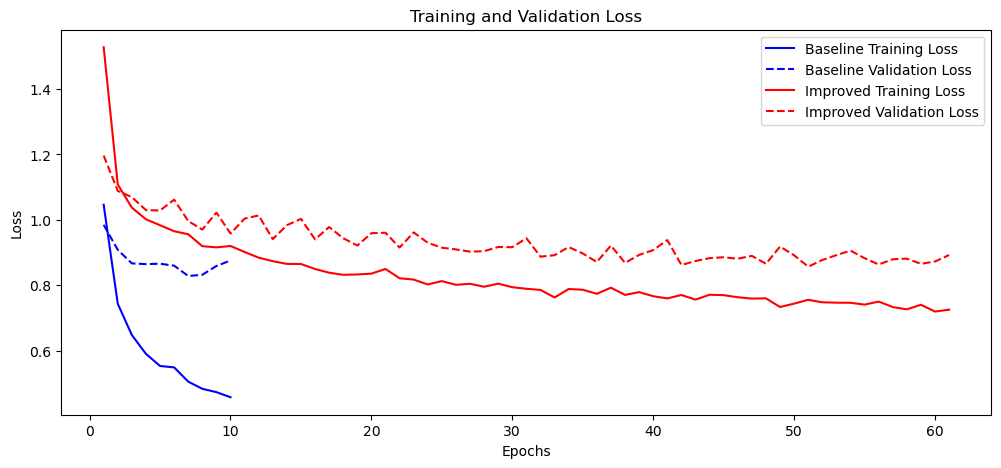

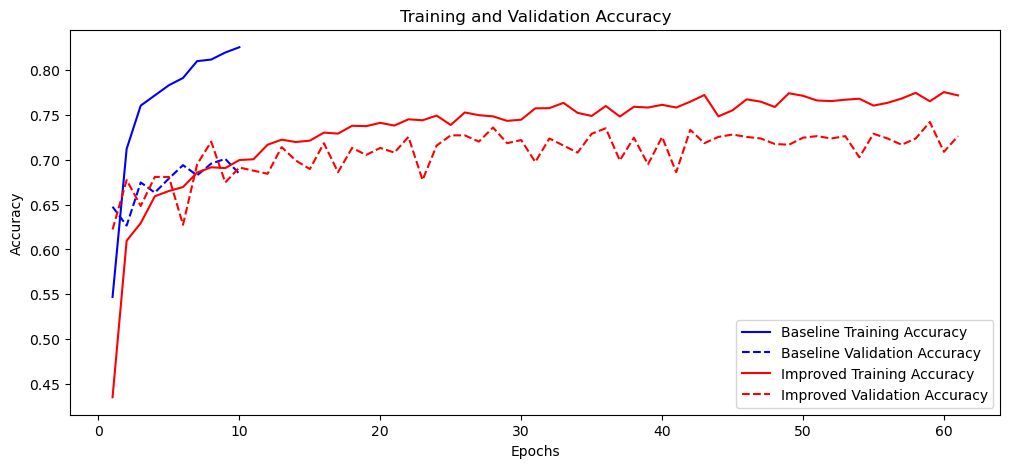

In [36]:
# Retrieve the histories from the baseline model and improved model
baseline_history = original_hist.history
improved_history = best_history.history

# Extract accuracy and loss values
baseline_acc = baseline_history['accuracy']
baseline_val_acc = baseline_history['val_accuracy']
baseline_loss = baseline_history['loss']
baseline_val_loss = baseline_history['val_loss']

improved_acc = improved_history['accuracy']
improved_val_acc = improved_history['val_accuracy']
improved_loss = improved_history['loss']
improved_val_loss = improved_history['val_loss']

# Determine the number of epochs for each model
baseline_epochs = range(1, len(baseline_acc) + 1)
improved_epochs = range(1, len(improved_acc) + 1)

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.plot(baseline_epochs, baseline_loss, 'b-', label='Baseline Training Loss')
plt.plot(baseline_epochs, baseline_val_loss, 'b--', label='Baseline Validation Loss')
plt.plot(improved_epochs, improved_loss, 'r-', label='Improved Training Loss')
plt.plot(improved_epochs, improved_val_loss, 'r--', label='Improved Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))
plt.plot(baseline_epochs, baseline_acc, 'b-', label='Baseline Training Accuracy')
plt.plot(baseline_epochs, baseline_val_acc, 'b--', label='Baseline Validation Accuracy')
plt.plot(improved_epochs, improved_acc, 'r-', label='Improved Training Accuracy')
plt.plot(improved_epochs, improved_val_acc, 'r--', label='Improved Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


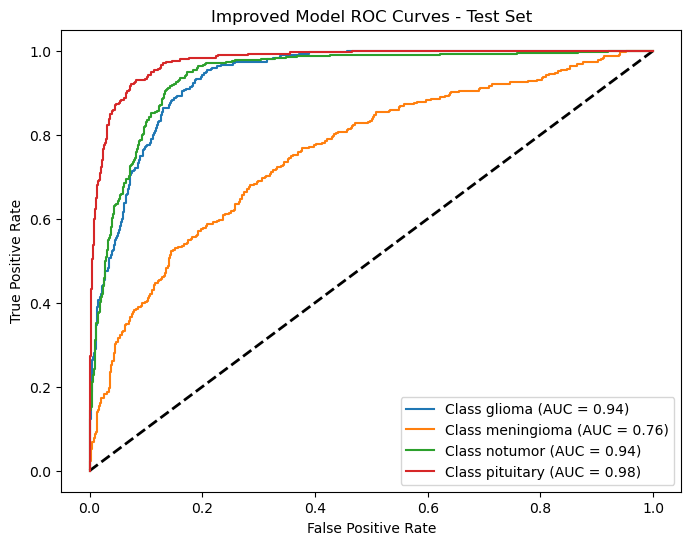

Test Set Macro AUC - Improved Model: 0.90


In [37]:
# Compute ROC curves with compute_roc_auc()
baseline_fpr_test, baseline_tpr_test, baseline_roc_auc_test, baseline_macro_auc_test = compute_roc_auc(best_model, test_data)

# Plot ROC curves for the test set
plt.figure(figsize=(8, 6))

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
for i in range(test_data.num_classes):
    plt.plot(baseline_fpr_test[i], baseline_tpr_test[i],
             label='Class {} (AUC = {:.2f})'.format(class_names[i], baseline_roc_auc_test[i]))

plt.title('Improved Model ROC Curves - Test Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

plt.show()

print(f'Test Set Macro AUC - Improved Model: {baseline_macro_auc_test:.2f}')

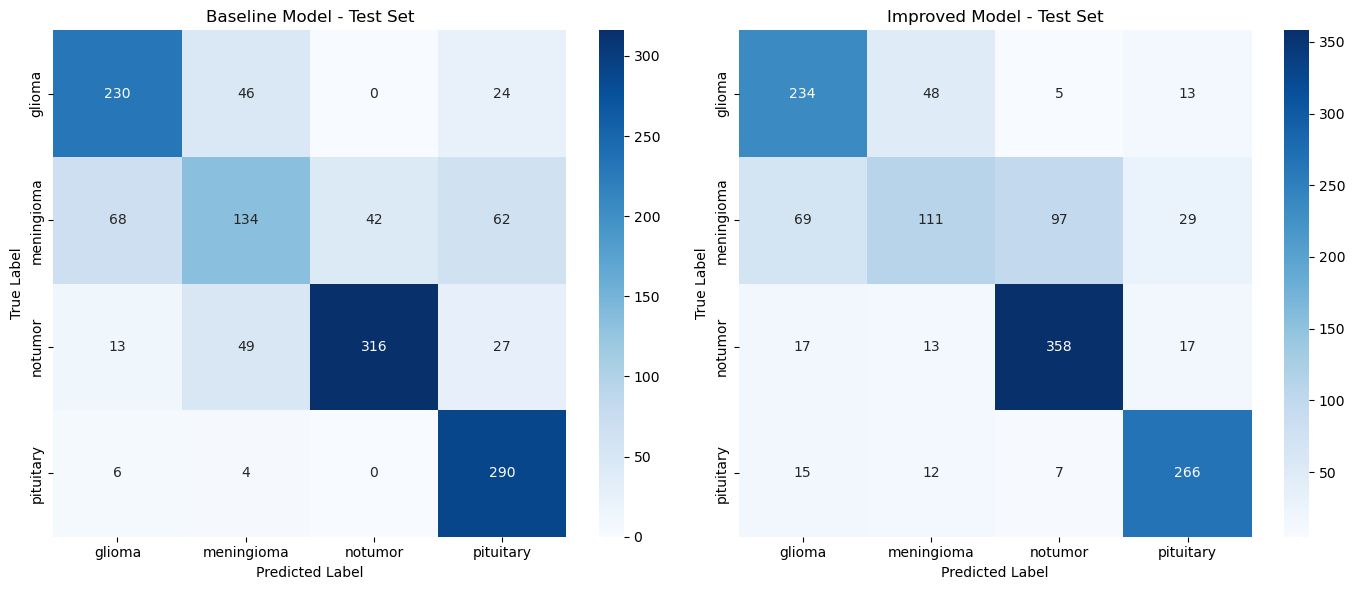

In [38]:
# Create confusion matrices with get_confusion_matrix()
baseline_conf_matrix_test = get_confusion_matrix(baseline_model, test_data)
improved_conf_matrix_test = get_confusion_matrix(best_model, test_data)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Baseline model
sns.heatmap(baseline_conf_matrix_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title('Baseline Model - Test Set')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Improved model
sns.heatmap(improved_conf_matrix_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title('Improved Model - Test Set')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

In [39]:
# Function to compute classification report
def get_classification_report(model, data_generator):
    y_true = []
    y_pred = []

    data_generator.reset()
    for i in range(len(data_generator)):
        images, labels = data_generator[i]
        preds = model.predict(images, verbose=0)
        predicted_labels = np.argmax(preds, axis=1)
        true_labels = np.argmax(labels, axis=1)
        y_true.extend(true_labels)
        y_pred.extend(predicted_labels)

    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    return report

### Classification report on validation set

In [40]:
# Get classification reports with get_classification_report()
baseline_report_test = get_classification_report(baseline_model, validation_generator)
improved_report_test = get_classification_report(best_model, validation_generator)

# Function to create performance DataFrame
def create_performance_dataframe(report, model_name):
    df = pd.DataFrame(report).transpose()
    df['model'] = model_name
    return df

# Create DataFrames for test set
baseline_df_test = create_performance_dataframe(baseline_report_test, 'Baseline')
improved_df_test = create_performance_dataframe(improved_report_test, 'Improved')

# Combine DataFrames
performance_df = pd.concat([baseline_df_test, improved_df_test])

# Select metrics
performance_df = performance_df[['precision', 'recall', 'f1-score', 'support', 'model']]
performance_df = performance_df.round(3)

# Rearrange columns
performance_df = performance_df.reset_index().rename(columns={'index': 'class'})

performance_df

,class,precision,recall,f1-score,support,model
0,glioma,0.758,0.830,0.792,264.000,Baseline
1,meningioma,0.518,0.491,0.504,267.000,Baseline
2,notumor,0.847,0.505,0.633,319.000,Baseline
3,pituitary,0.658,0.924,0.769,291.000,Baseline
4,accuracy,0.684,0.684,0.684,0.684,Baseline
5,macro avg,0.695,0.687,0.674,1141.000,Baseline
6,weighted avg,0.701,0.684,0.674,1141.000,Baseline
7,glioma,0.727,0.867,0.791,264.000,Improved
8,meningioma,0.583,0.382,0.462,267.000,Improved
9,notumor,0.703,0.734,0.718,319.000,Improved


### Classification report on test set

In [41]:
# Get classification reports with get_classification_report()
baseline_report_test = get_classification_report(baseline_model, test_data)
improved_report_test = get_classification_report(best_model, test_data)

# Create DataFrames for test set
baseline_df_test = create_performance_dataframe(baseline_report_test, 'Baseline')
improved_df_test = create_performance_dataframe(improved_report_test, 'Improved')

# Combine DataFrames
performance_df = pd.concat([baseline_df_test, improved_df_test])

# Select metrics
performance_df = performance_df[['precision', 'recall', 'f1-score', 'support', 'model']]
performance_df = performance_df.round(3)

# Rearrange columns
performance_df = performance_df.reset_index().rename(columns={'index': 'class'})

performance_df

,class,precision,recall,f1-score,support,model
0,glioma,0.723,0.757,0.739,300.000,Baseline
1,meningioma,0.586,0.454,0.512,306.000,Baseline
2,notumor,0.875,0.793,0.832,405.000,Baseline
3,pituitary,0.730,0.957,0.828,300.000,Baseline
4,accuracy,0.743,0.743,0.743,0.743,Baseline
5,macro avg,0.729,0.740,0.728,1311.000,Baseline
6,weighted avg,0.740,0.743,0.735,1311.000,Baseline
7,glioma,0.684,0.780,0.729,300.000,Improved
8,meningioma,0.588,0.340,0.431,306.000,Improved
9,notumor,0.767,0.886,0.822,405.000,Improved


# 8. Transfer learning from VGG16

Next, train a new model using transfer learning. Utilize either VGG16, ResNet50,
or DenseNet121 architecture for feature extraction. Freeze the layers until the fully
connected layer such that these layers will not be updated through training. Add your
fully connected layers (as many as you like) and present the results that you obtained
on the test set (ROC curve with AUC score, performance measures, and confusion
matrix). Comment on the performance with respect to the baseline and the network
that you designed in the previous step.

In [42]:
def create_transfer_learning_model(input_shape=(30, 30, 1), num_classes=4):
    # Input layer for grayscale images (30x30x1)
    input_layer = layers.Input(shape=input_shape)
    
    x = layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(input_layer)
    
    # Convert grayscale images to RGB by duplicating the channel
    x = layers.Concatenate()([x, x, x])
    
    # Load the pre-trained VGG16 model without the top layers
    vgg16_base = VGG16(weights='imagenet', include_top=False)
    
    # Freeze the convolutional base
    for layer in vgg16_base.layers:
        layer.trainable = False
    
    # Pass the input through the VGG16 base model
    x = vgg16_base(x)
    
    # Flatten the output and add new fully connected layers
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    output_layer = layers.Dense(num_classes, activation='softmax')(x)
    
    # Create and compile the new model
    model = models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Create the transfer learning model
transfer_learning_model = create_transfer_learning_model()

transfer_learning_model.summary()

Model: "functional_664"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_85      │ (None, 30, 30, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 224, 224,  │          0 │ input_layer_85[0… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 224, 224,  │          0 │ lambda_1[0][0],   │
│ (Concatenate)       │ 3)                │            │ lambda_1[0][0],   │
│                     │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_84          │ (None, 25088)     │          0 │ vgg16[0][0]       │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_169 (Dense)   │ (None, 128)       │  3,211,392 │ flatten_84[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_170 (Dense)   │ (None, 32)        │      4,128 │ dense_169[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_171 (Dense)   │ (None, 4)         │        132 │ dense_170[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,930,340 (68.40 MB)

 Trainable params: 3,215,652 (12.27 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [43]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Train the model
history = transfer_learning_model.fit(train_generator, 
                                      epochs=100, 
                                      validation_data=validation_generator, 
                                      callbacks=[early_stopping],verbose=1
                                     )

transfer_learning_history = history
test_loss, test_acc = transfer_learning_model.evaluate(test_data)
print(f"Test accuracy: {test_acc}")

Epoch 1/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - accuracy: 0.4349 - loss: 1.4755 - val_accuracy: 0.5425 - val_loss: 1.1389
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.6451 - loss: 0.8414 - val_accuracy: 0.5653 - val_loss: 1.0300
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.6909 - loss: 0.7351 - val_accuracy: 0.6214 - val_loss: 0.9592
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.6726 - loss: 0.7359 - val_accuracy: 0.6301 - val_loss: 0.9428
Epoch 5/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.7366 - loss: 0.6619 - val_accuracy: 0.6442 - val_loss: 0.9605
Epoch 6/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.7337 - loss: 0.6576 - val_accuracy: 0.5968 - val_loss: 1.0680
Epoch 7/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.7345 - loss: 0.6339 - val_accuracy: 0.6529 - val_loss: 0.9229
Epoch 8/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.7374 - loss: 0.6251 -

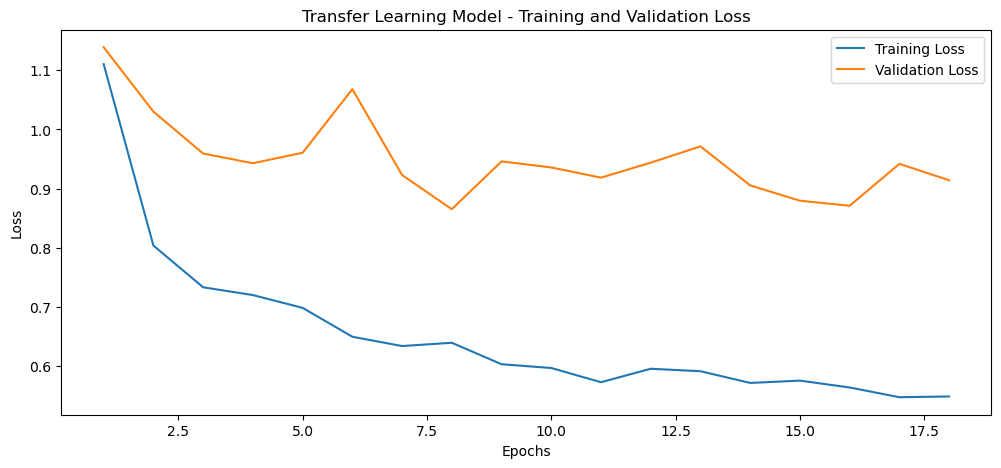

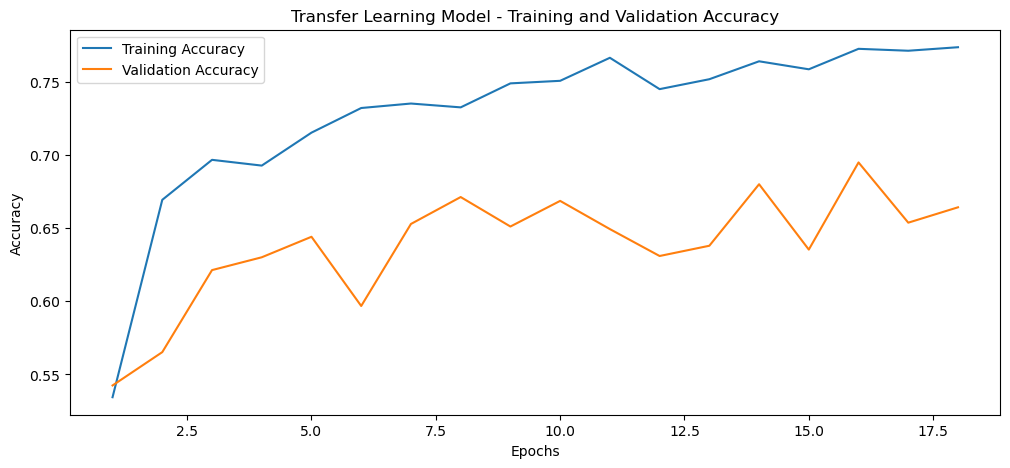

In [44]:
# Retrieve the history from the transfer learning model
history_dict = transfer_learning_history.history

# Extract accuracy and loss values
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Determine the number of epochs
epochs_range = range(1, len(acc) + 1)

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Transfer Learning Model - Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Transfer Learning Model - Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


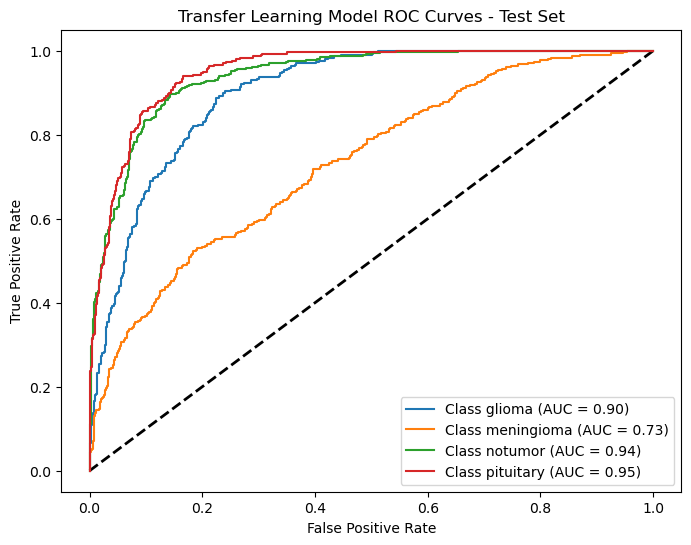

Test Set Macro AUC - Transfer Learning Model: 0.88


In [45]:
# Compute ROC curves with compute_roc_auc()
baseline_fpr_test, baseline_tpr_test, baseline_roc_auc_test, baseline_macro_auc_test = compute_roc_auc(transfer_learning_model, test_data)

# Plot ROC curves for the test set
plt.figure(figsize=(8, 6))

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
for i in range(test_data.num_classes):
    plt.plot(baseline_fpr_test[i], baseline_tpr_test[i],
             label='Class {} (AUC = {:.2f})'.format(class_names[i], baseline_roc_auc_test[i]))

plt.title('Transfer Learning Model ROC Curves - Test Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

plt.show()

print(f'Test Set Macro AUC - Transfer Learning Model: {baseline_macro_auc_test:.2f}')

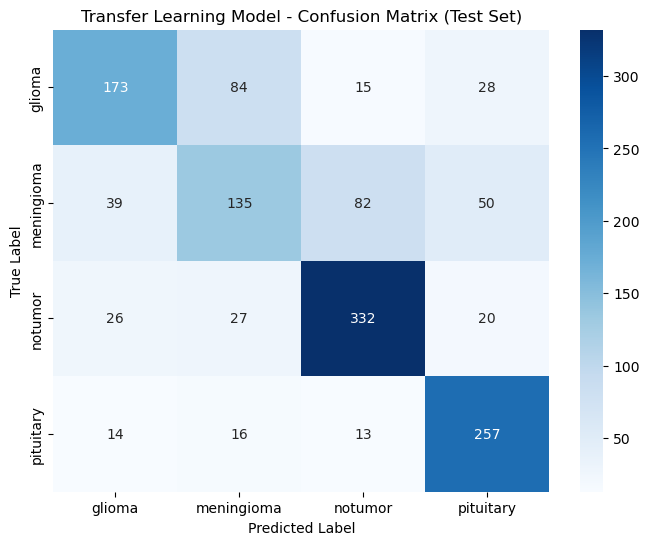

In [46]:
# Get confusion matrix with get_confusion_matrix()
conf_matrix_test = get_confusion_matrix(transfer_learning_model, test_data)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Transfer Learning Model - Confusion Matrix (Test Set)')
plt.show()

In [47]:
# Get classification reports with get_classification_report()
report_test = get_classification_report(transfer_learning_model, test_data)

# Create DataFrame for test set
df_test = create_performance_dataframe(report_test, 'Transfer Learning Model')

# Select metrics
df_test = df_test[['precision', 'recall', 'f1-score', 'support', 'model']]
df_test = df_test.round(3)

# Rearrange columns
df_test = df_test.reset_index().rename(columns={'index': 'class'})

df_test

,class,precision,recall,f1-score,support,model
0,glioma,0.649,0.543,0.592,300.000,Transfer Learning Model
1,meningioma,0.493,0.461,0.476,306.000,Transfer Learning Model
2,notumor,0.777,0.790,0.783,405.000,Transfer Learning Model
3,pituitary,0.718,0.867,0.785,300.000,Transfer Learning Model
4,accuracy,0.674,0.674,0.674,0.674,Transfer Learning Model
5,macro avg,0.659,0.665,0.659,1311.000,Transfer Learning Model
6,weighted avg,0.668,0.674,0.668,1311.000,Transfer Learning Model
